# Feature Processing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from utils import *
from feature_settings import *

Import the cleaned oneDTE file and other files

In [2]:
# cleaned oneDTE
file_path = os.getcwd() + '\\' + 'intermediate_files' + '\\' + 'cleaned_oneDTE_with_settlements.csv'
whole_df = pd.read_csv(file_path)

# security prices
security_prices_df = pd.read_csv(r"raw_data\OpitonMetrics\securities_data\security_prices.csv")

# historical vol
historical_vol_df = pd.read_csv(r"raw_data\OpitonMetrics\options_data\historical_vol.csv")

# forward prices
forward_prices_df = pd.read_csv(r"raw_data\OpitonMetrics\options_data\forward_price.csv")

# fama french 5 factors
fama_french_factors_df = pd.read_csv(r"raw_data\FamaFrench\5_factors.csv")

# cboe vix
cboe_index_df = pd.read_csv(r"raw_data\Cboe\volatility_index.csv")

# volume and open interest
volume_open_interest_df = pd.read_csv(r"raw_data\OpitonMetrics\options_data\volume_open_interest.csv")


C:\Users\55479\AppData\Local\Temp\ipykernel_8440\538068376.py:3: DtypeWarning: Columns (24,25) have mixed types. Specify dtype option on import or set low_memory=False.
  whole_df = pd.read_csv(file_path)


Check implied vol and greeks

In [3]:
# check the percentage of the data with complete vol and greeks
whole_df_missing_greeks = whole_df[
    (pd.isna(whole_df['impl_volatility'])) |
    (pd.isna(whole_df['delta'])) |
    (pd.isna(whole_df['gamma'])) |
    (pd.isna(whole_df['vega'])) |
    (pd.isna(whole_df['theta']))
]

print(f'The rest percentage after removing the greeks is {1-len(whole_df_missing_greeks)/len(whole_df):.4f}')

# check the percentage of the data with complete vol and greeks

greeks_and_vol = ['impl_volatility', 'delta', 'gamma', 'theta', 'vega']
for each in greeks_and_vol:
    whole_df_missing_greeks = whole_df[
    (pd.isna(whole_df[each]))
]
    print(f'The rest percentage after removing the {each} is {1-len(whole_df_missing_greeks)/len(whole_df):.4f}')

# in this way, we know that if one of the greeks and vol is blank, then all the others are also blank
# after removing all the blanks, then the rest is only around 66% (too many have been removed)
# but this can serve as robustness check
print('\n')
print(f'For vol and greeks, if one is blank, all the others are blank, too')


The rest percentage after removing the greeks is 0.6596
The rest percentage after removing the impl_volatility is 0.6596
The rest percentage after removing the delta is 0.6596
The rest percentage after removing the gamma is 0.6596
The rest percentage after removing the theta is 0.6596
The rest percentage after removing the vega is 0.6596


For vol and greeks, if one is blank, all the others are blank, too


# Add features

In [4]:
# dividend rate (annualized already) all 0
# standardized moneyness (pending, different definitions)

# features summary:

# ---option basic information---:
# put-call flag indicator (int, call 1 put 0) I
# AM settlement indicator (int, am settle 1 pm settle 0)
# strike price (/1000) K
# settlement value ST
# mid-point option price C or P
# payoff
# simple payoff return
# best offer return
# best bid return (if the bid price is 0, then we assume no one will buy the option, so return is 0)
# intrinsic value
# risk free interest rate (from fama french)
# risk free interest rate annualized


# ---option advanced information---:
# moneyness: St/K (current market closing price / strike price)
# log transformation of moneyness
# bid-ask spread (difference)
# bid-ask spread (percentage)
# scaled option price C,P / K
# scaled best offer best_offer / K
# scaled best bid best_bid / K


# --- aggregated open interest and volume ---:
# total call volume
# total put volume
# total volume
# total call open interest
# total put open interest
# total interest


# --- CBOE VIX ---:
# VIX open
# VIX close
# VIX high
# VIX low

# --- fama french ---:
# 5 factors


# ---security prices---:
# high and lags
# low and lags
# open and lags
# close and lags
# return and lags


# ---historical vol---:
# day 10 and lags
# day 14 and lags
# day 30 and lags
# day 60 and lags
# day 91 and lags
# day 122 and lags
# day 152 and lags
# day 182 and lags
# day 273 and lags
# day 365 and lags
# day 547 and lags
# day 730 and lags
# day 1825 and lags


# ---forward price---:
# forward price (no need to get lag, since the previous day's close price is known)

# ---time features---:
# year
# month
# day



# --------------------------------------------------------> for straddle and ATM with implied vol <--------------------------------------------------

# ---TUDelft ---:
# time value (price - intrinsic value)
# log(time value / K), log transformation (scaled) of time value


# --- option market lead (paper) ---:

# 1 avg impl volatility Average ATM implied volatility
# 2 cvol Change in ATM Call implied volatility (An, Ang, Bali, and Cakici (2014)) 
# 3 cw CW difference between implied vol of put and call (Cremers and Weinbaum (2012)) 
# 4 hviv Historical volatility - Implied ATM volatility (Goyal and Saretto (2009)) 
# 5 med hq Option implied fee (Muravyev, Pearson, and Pollet (2018)) 
# 6 opt baspread Option average bid-ask spread 
# 7 os OS ratio (Johnson and So (2012)) 
# 8 pvol Change in ATM Put implied volatility (An, Ang, Bali, and Cakici (2014)) 
# 9 skewness Volatility surface skewness (Xing, Zhang, and Zhao (2010))

# can be done
# 1 implied vol
# 3 difference between implied vols (only straddle)
# 4 historical vol - average implied vol (only straddle)
# 6 average bid-ask spread (only straddle)
# + volume summation (only straddle)
# + open interest summation (only straddle)
# + average implied vol (only straddle)


datetime, year, month, date

In [5]:
# convert the datetime
whole_df['datetime'] = pd.to_datetime(whole_df['date'])
whole_df['year'] = whole_df['datetime'].dt.year
whole_df['month'] = whole_df['datetime'].dt.month
whole_df['day'] = whole_df['datetime'].dt.day

put call int flag, 0 is put and 1 is call

In [6]:
# Call and put option flag (call is 1 and put is 0)
whole_df['cp_flag_num'] = whole_df['cp_flag'].map({'P': int(0), 'C': int(1)})

# the set of cp_flag is only C and P
print(f"In the data there are only call and put options: {set(whole_df['cp_flag'])}")

In the data there are only call and put options: {'P', 'C'}


am pm settlement int flag, 0 is pm and 1 is am

In [7]:
# am settlement is 1, pm settlement is 0
whole_df['am_settlement_num'] = whole_df['settlement_symbol'].map({'SET': int(1), 'SPX': int(0), 'SPXPM': int(0)})

# check there are only SPX, SET and SPXPM
print(f"In the data there are only SET, SPX and SPXPM of settlement symbol: {set(whole_df['settlement_symbol'])}")

In the data there are only SET, SPX and SPXPM of settlement symbol: {'SPX', 'SET', 'SPXPM'}


normal strike price

In [8]:
# Create the strike K
whole_df['strike'] = whole_df['strike_price']/1000

# strike price should be always greater than 0
print(f"All strike prices are > 0: {all(i > 0 for i in whole_df['strike'])}")

All strike prices are > 0: True


payoff (future real stock price and strike price)

In [9]:
# I * Max(ST - K, 0) + (1-I) * Max(K - ST, 0)
whole_df['payoff'] = np.maximum(whole_df['settlement_value'] - whole_df['strike'], 0) * whole_df['cp_flag_num'] + \
                     np.maximum(whole_df['strike'] - whole_df['settlement_value'], 0) * (1 - whole_df['cp_flag_num'])

# payoff should be always greater than or equal to 0
print(f"All payoffs are >= 0: {all(i >= 0 for i in whole_df['payoff'])}")

All payoffs are >= 0: True


mid-point closing option price

In [10]:
# Create the option price, which is the mid-point of best bid and bid ask at the market closing time
whole_df['option_price'] = (whole_df['best_bid'] + whole_df['best_offer']) / 2

# check if the best bid is always smaller than the best offer
print(f"Bid <= Offer: {all(whole_df['best_bid'] <= whole_df['best_offer'])}")

# check if the best bid and best offer are both >= 0
print(f"Best bid and best offer are both >= 0: {all(i >= 0 for i in whole_df['best_bid']) and all(i >= 0 for i in whole_df['best_offer'])}")
print(f"Best offer is always > 0: {all(i > 0 for i in whole_df['best_offer'])}")

# so if we long the underlying, we can use the closing price of index

Bid <= Offer: True
Best bid and best offer are both >= 0: True
Best offer is always > 0: True


scaled option price

scaled best offer

scaled best bid

In [11]:
# C / K or P / K
whole_df['scaled_option_price'] = whole_df['option_price'] / whole_df['strike']

# best_offer / K
whole_df['scaled_best_offer'] = whole_df['best_offer'] / whole_df['strike']

# best_bid / K
whole_df['scaled_best_bid'] = whole_df['best_bid'] / whole_df['strike']

# all >= 0 since all strikes are > 0

simple payoff function return

best offer return

best bid return

In [12]:
# Calculate the option return
whole_df['option_return'] = (whole_df['payoff'] - whole_df['option_price']) / whole_df['option_price']
whole_df['best_offer_return'] = (whole_df['payoff'] - whole_df['best_offer']) / whole_df['best_offer']
whole_df['best_bid_return'] = np.where(
    whole_df['best_bid'] != 0,
    (whole_df['payoff'] - whole_df['best_bid']) / whole_df['best_bid'],
    0
)

# get the mean, vol and signal to noise ratio
print(f'The mean of all option returns is : {whole_df["option_return"].mean()}')
print(f'The vol of all option returns is : {whole_df["option_return"].std()}')
print(f'The signal to noise ratio of all option returns is : {whole_df["option_return"].mean() / whole_df["option_return"].std()}')
print('\n')

print(f'The mean of best offer returns is : {whole_df["best_offer_return"].mean()}')
print(f'The vol of best offer returns is : {whole_df["best_offer_return"].std()}')
print(f'The signal to noise ratio of best offer returns is : {whole_df["best_offer_return"].mean() / whole_df["best_offer_return"].std()}')
print('\n')

print(f'The mean of best bid returns is : {whole_df["best_bid_return"].mean()}')
print(f'The vol of best bid returns is : {whole_df["best_bid_return"].std()}')
print(f'The signal to noise ratio of best bid returns is : {whole_df["best_bid_return"].mean() / whole_df["best_bid_return"].std()}')

# explain why the mean option return is negative

The mean of all option returns is : -0.4413808218391128
The vol of all option returns is : 1.2566085229628339
The signal to noise ratio of all option returns is : -0.35124767481158276


The mean of best offer returns is : -0.4511917425596768
The vol of best offer returns is : 1.114346433464952
The signal to noise ratio of best offer returns is : -0.40489360311114375


The mean of best bid returns is : -0.0983444109905338
The vol of best bid returns is : 1.6003197242583274
The signal to noise ratio of best bid returns is : -0.06145297686442738


security prices: low, high, open, close, return

moneyness lags

In [13]:
# only get the useful columns
security_prices_df_to_merge = security_prices_df[['date', 'low', 'high', 'open', 'close', 'return']]

# -----------------------------------create the lags---------------------------------
security_lags = {
    'low': 0,
    'high': 0,
    'open': 0,
    'close': 0,
    'return': 0,
}

for item, num_lag in security_lags.items():
    for i in range(1, num_lag + 1):
        security_prices_df_to_merge[f"{item}_lag_{i}"] = security_prices_df_to_merge[item].shift(i)

# merge the two data frames
intermediate_security_merge_df = pd.merge(whole_df, security_prices_df_to_merge, on='date', how='left')


whole_df['stock_low_price'] = intermediate_security_merge_df['low']
whole_df['stock_high_price'] = intermediate_security_merge_df['high']
whole_df['stock_open_price'] = intermediate_security_merge_df['open']
whole_df['stock_close_price'] = intermediate_security_merge_df['close']
whole_df['stock_return'] = intermediate_security_merge_df['return']

# add all the lags
for item, num_lag in security_lags.items():
    for i in range(1, num_lag + 1):
        whole_df[f"stock_{item}_lag_{i}"] = intermediate_security_merge_df[f"{item}_lag_{i}"]
        if item == 'close':
            whole_df[f"moneyness_lag_{i}"] = whole_df[f"stock_{item}_lag_{i}"] / whole_df['strike']

# return is calculated by the market closing price, one day backward

intrinsic value

In [14]:
# similar to payoff
whole_df['intrinsic_value'] = np.maximum(whole_df['stock_close_price'] - whole_df['strike'], 0) * whole_df['cp_flag_num'] + \
                              np.maximum(whole_df['strike'] - whole_df['stock_close_price'], 0) * (1 - whole_df['cp_flag_num'])

moneyness 

log transformatino of moneyness

The average moneyness of all options is 1.177257113308589


The equally wegihted average moneyness of profitable options is 1.1814739348306773
The return wegihted average moneyness of profitable options is 1.0120680923195517


The equally wegihted average moneyness of non-profitable options is 1.175629030289275
The return wegihted average moneyness of non-profitable options is 1.1684126654183273


The equally wegihted average moneyness of profitable options based on bid price is 1.1852120994832882
The return wegihted average moneyness of profitable options based on bid price is 1.013440276629343


The equally wegihted average moneyness of non-profitable options based on bid price is 1.1043712764805775
The return wegihted average moneyness of non-profitable options based on bid price is 1.029101312175633


The equally wegihted average moneyness of profitable options based on offer price is 1.174007737758525
The return wegihted average moneyness of profitable options based on offer price

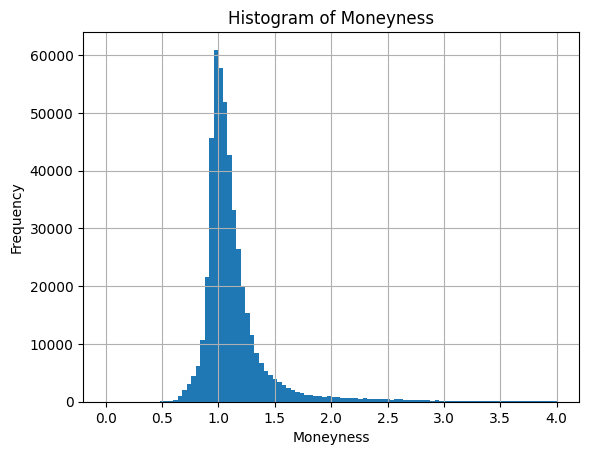

In [15]:
# St/K (market closing price / strike)
# log
whole_df['moneyness'] = whole_df['stock_close_price'] / whole_df['strike']
whole_df['log_moneyness'] = np.log(whole_df['moneyness'])

# check if the positive profit centers at ATM
print(f"The average moneyness of all options is {whole_df['moneyness'].mean()}")
print('\n')
print(f"The equally wegihted average moneyness of profitable options is {whole_df[whole_df['option_return'] > 0]['moneyness'].mean()}")
print(f"The return wegihted average moneyness of profitable options is {np.average(whole_df[whole_df['option_return'] > 0]['moneyness'], weights=whole_df[whole_df['option_return'] > 0]['option_return'])}")
print('\n')
print(f"The equally wegihted average moneyness of non-profitable options is {whole_df[whole_df['option_return'] < 0]['moneyness'].mean()}")
print(f"The return wegihted average moneyness of non-profitable options is {np.average(whole_df[whole_df['option_return'] < 0]['moneyness'], weights=whole_df[whole_df['option_return'] < 0]['option_return'])}")
print('\n')
print(f"The equally wegihted average moneyness of profitable options based on bid price is {whole_df[whole_df['best_bid_return'] > 0]['moneyness'].mean()}")
print(f"The return wegihted average moneyness of profitable options based on bid price is {np.average(whole_df[whole_df['best_bid_return'] > 0]['moneyness'], weights=whole_df[whole_df['best_bid_return'] > 0]['best_bid_return'])}")
print('\n')
print(f"The equally wegihted average moneyness of non-profitable options based on bid price is {whole_df[whole_df['best_bid_return'] < 0]['moneyness'].mean()}")
print(f"The return wegihted average moneyness of non-profitable options based on bid price is {np.average(whole_df[whole_df['best_bid_return'] < 0]['moneyness'], weights=whole_df[whole_df['best_bid_return'] < 0]['best_bid_return'])}")
print('\n')
print(f"The equally wegihted average moneyness of profitable options based on offer price is {whole_df[whole_df['best_offer_return'] > 0]['moneyness'].mean()}")
print(f"The return wegihted average moneyness of profitable options based on offer price is {np.average(whole_df[whole_df['best_offer_return'] > 0]['moneyness'], weights=whole_df[whole_df['best_offer_return'] > 0]['best_offer_return'])}")
print('\n')
print(f"The equally wegihted average moneyness of non-profitable options based on offer price is {whole_df[whole_df['best_offer_return'] < 0]['moneyness'].mean()}")
print(f"The return wegihted average moneyness of non-profitable options based on offer price is {np.average(whole_df[whole_df['best_offer_return'] < 0]['moneyness'], weights=whole_df[whole_df['best_offer_return'] < 0]['best_offer_return'])}")
print('\n')
# check the range of 1DTE moneyness
print(f"The upper bound of the moneyness is {whole_df['moneyness'].max()}, the lower bound is {whole_df['moneyness'].min()}")

# draw a graph to show the distribution of the moneyness
whole_df['moneyness'].hist(bins=100, range=(0, 4))
plt.xlabel('Moneyness')
plt.ylabel('Frequency')
plt.title('Histogram of Moneyness')
plt.show()
# so averagingly, the profitable option is ATM

bid-ask spread

bid-ask spread percentage

In [16]:
# bid-ask spread is defined as ask - bid
whole_df['bid_ask_spread'] = whole_df['best_offer'] - whole_df['best_bid']

whole_df['bid_ask_spread_percentage'] = whole_df['bid_ask_spread'] / whole_df['option_price']

# check if there is negative value for bid ask spread
print(f"There is no negative value for bid-ask spread: {all(i >= 0 for i in whole_df['bid_ask_spread'])}")

There is no negative value for bid-ask spread: True


historical vol and lags

In [17]:
# pivot the table and convert the days to cols
historical_vol_df_pivot = historical_vol_df.pivot(index='date', columns='days', values='volatility')
historical_vol_df_pivot.columns = [f'vol_days_{i}' for i in historical_vol_df_pivot.columns]
historical_vol_df_pivot = historical_vol_df_pivot.reset_index()

#------------------------------------------------- create lags ---------------------------------------
historical_lags = {
    'vol_days_10': 0,
    'vol_days_14': 0, 
    'vol_days_30': 0, 
    'vol_days_60': 0, 
    'vol_days_91': 0, 
    'vol_days_122': 0, 
    'vol_days_152': 0, 
    'vol_days_182': 0, 
    'vol_days_273': 0,
    'vol_days_365': 0,
    'vol_days_547': 0,
    'vol_days_730': 0,
    'vol_days_1825': 0,
}

for item, num_lag in historical_lags.items():
    for i in range(1, num_lag + 1):
        historical_vol_df_pivot[f"{item}_lag_{i}"] = historical_vol_df_pivot[item].shift(i)

# merge the data frame
intermediate_historical_vol_merge_df = pd.merge(whole_df, historical_vol_df_pivot, on='date', how='left')

# add all features
for i in historical_vol_df_pivot.keys():
    whole_df[i] = intermediate_historical_vol_merge_df[i]

implied vol and greeks analysis

In [18]:
# 5 reasons from OptionMetrics that there is no implied vol

# Special settlement	        Optional	Market/data-specific -> no special settlement
# Price below intrinsic value	Yes	        Model requirement
# Vega < 0.5	                Optional	Stability/practicality -> there is vega < 0.5
# IV calculation fails	        Yes	        Mathematical necessity
# Missing underlying price	    Yes	        Required input

In [19]:
# 3 real reasons for implied vol missing

# Price below intrinsic value	Yes	        Model requirement -------------> we can do something
# IV calculation fails	        Yes	        Mathematical necessity --------> technical issue that we cannot solve
# Missing underlying price	    Yes	        Required input ----------------> technical issue that we cannot solve

In [20]:
# check the special settlement
print(f"All the option of oneDTE are all non-special settled: {all(int(i) == 0 for i in whole_df['ss_flag'])}")

# check if there is vega < 0.5
print(f"In the oneDTE data there is vega < 0.5: {any(i < 0.5 for i in whole_df['vega'])}")

# check the percentage of blank implied vol caused by wrong price with intrinsic value
print(f"The percentage of blank implied vol caused by wrong relation between option price and intrinsic value is: " + 
      f"{len(whole_df[whole_df['option_price'] < whole_df['intrinsic_value']])/len(whole_df[whole_df['impl_volatility'].isna()]):.4f}")

print(len(whole_df[whole_df['option_price'] < whole_df['intrinsic_value']])/len(whole_df))


All the option of oneDTE are all non-special settled: True
In the oneDTE data there is vega < 0.5: True
The percentage of blank implied vol caused by wrong relation between option price and intrinsic value is: 0.6814
0.23191830429076896


forward price

In [21]:
# align the column names to be merged
forward_prices_df['am_settlement_num'] = forward_prices_df['AMSettlement']
forward_prices_df['exdate'] = forward_prices_df['expiration']

# get the forward price data frame to be merged
forward_prices_df_to_be_merged = forward_prices_df[['date', 'exdate', 'am_settlement_num', 'ForwardPrice']]

# merge to get the intermediate merged data
intermediate_forward_prices_df_merge = pd.merge(whole_df, forward_prices_df_to_be_merged, on=['date', 'exdate', 'am_settlement_num'], how='left')

# assign the forward price to the whole_df
whole_df['filled_forward_price'] = intermediate_forward_prices_df_merge['ForwardPrice']

# check if there's any missing value
print(f"There is no missing value in forward price: {not whole_df['filled_forward_price'].isna().any()}")
print('\n')

# so there is missing value, let's fill it in
# first of all, save all the missing forward price for later analysis
file_path = os.getcwd() + '\\' + 'intermediate_files' + '\\' + 'missing_forward_price_df.csv'
whole_df[pd.isna(whole_df['filled_forward_price'])].to_csv(file_path, index=False)

# second, fill in the values
historical_forward_price = {}

for index, i in whole_df.iterrows():
    if not whole_df['filled_forward_price'].isna().any():
        break
    
    if pd.isna(i['filled_forward_price']):

        if (i['date'], i['exdate']) in historical_forward_price.keys():
            whole_df.at[index, 'filled_forward_price'] = historical_forward_price[(i['date'], i['exdate'])]

        else:
            for index_2, j in forward_prices_df.iterrows():
                if (
                    i['date'] == j['date'] and 
                    i['exdate'] == j['expiration']
                ):
                    whole_df.at[index, 'filled_forward_price'] = j['ForwardPrice']
                    historical_forward_price[(i['date'], i['exdate'])] = j['ForwardPrice']
                    break

# final check
print(f"There is no missing value in forward price: {not whole_df['filled_forward_price'].isna().any()}")

There is no missing value in forward price: False


There is no missing value in forward price: True


Fama French 5 factors

risk free rate

In [22]:
# create the merged data frame
fama_french_df_merge = pd.merge(whole_df, fama_french_factors_df, on='date', how='left')

# assgin the new cols to the current whole_df
features = ['mktrf', 'smb', 'hml', 'rmw', 'cma', 'umd', 'rf']

for feature in features:
    whole_df[feature] = fama_french_df_merge[feature]

annualized risk free rate

In [23]:
# annualize the rf by doing the compounded rate accumulation
whole_df['rf_annual'] = (1 + whole_df['rf'])**253 - 1

vix

In [24]:
# extract the vix from cboe index
features = ['vixo', 'vixh', 'vixl', 'vix']
cboe_index_df = cboe_index_df.drop_duplicates(subset='Date')
cboe_index_df['date'] = cboe_index_df['Date']

# get the merged data frame
intermediate_vix_df_merge = pd.merge(whole_df, cboe_index_df[features + ['date'] ], on='date', how='left')

# assign the cols to whole_df
for feature in features:
    whole_df[feature] = intermediate_vix_df_merge[feature]

print(f"There is no missing value for the vix: {not whole_df[features].isna().any().any()}")

There is no missing value for the vix: True


volume and open interest

In [25]:
# fill in the total flag by "T"
volume_open_interest_df = volume_open_interest_df.fillna({'cp_flag': 'T'})

# pivot th table, change the name of cols and reset the index
volume_open_interest_df_pivot = volume_open_interest_df.pivot(index='date', columns='cp_flag', values=['volume', 'open_interest'])
volume_open_interest_df_pivot.columns = ['call_total_volume', 'put_total_volume', 'total_volume', 'call_total_open_interest', 'put_total_open_interest', 'total_open_interest']
volume_open_interest_df_pivot = volume_open_interest_df_pivot.reset_index()

# merge the pivot table with whole_df to get the merged dataset
volume_open_interest_df_pivot_merged = pd.merge(whole_df, volume_open_interest_df_pivot, on='date', how='left')

# assign the columns to the whole_df
for i in ['call_total_volume', 'put_total_volume', 'total_volume', 'call_total_open_interest', 'put_total_open_interest', 'total_open_interest']:
    whole_df[i] = volume_open_interest_df_pivot_merged[i]

--------------------------------------------------------generate the file with all features--------------------------------------

In [26]:
file_path = os.getcwd() + '\\' + 'intermediate_files' + '\\' + 'whole_df.csv'
whole_df.to_csv(file_path, index=False)

# Call and put atm options

In [27]:
# split into am, pm call options and put options
am_call_df = whole_df[(whole_df['cp_flag_num'] == 1) & (whole_df['am_settlement_num'] == 1)]
am_put_df = whole_df[(whole_df['cp_flag_num'] == 0) & (whole_df['am_settlement_num'] == 1)]

pm_call_df = whole_df[(whole_df['cp_flag_num'] == 1) & (whole_df['am_settlement_num'] == 0)]
pm_put_df = whole_df[(whole_df['cp_flag_num'] == 0) & (whole_df['am_settlement_num'] == 0)]

# for both call and put, find the option moneyness closet to 1
am_call_atm_df = am_call_df.groupby('exdate').apply(find_atm_option, include_groups=False).reset_index(drop=True)
am_put_atm_df = am_put_df.groupby('exdate').apply(find_atm_option, include_groups=False).reset_index(drop=True)

pm_call_atm_df = pm_call_df.groupby('exdate').apply(find_atm_option, include_groups=False).reset_index(drop=True)
pm_put_atm_df = pm_put_df.groupby('exdate').apply(find_atm_option, include_groups=False).reset_index(drop=True)

print((set(am_call_atm_df['date']) | set(am_put_atm_df['date'])) - (set(am_call_atm_df['date']) & set(am_put_atm_df['date'])))

# check if the dates and settlement value correspond or not
is_true = (
    pm_call_atm_df['date'].equals(pm_put_atm_df['date']) and 
    pm_call_atm_df['settlement_value'].equals(pm_put_atm_df['settlement_value']) and 
    pm_call_atm_df['strike'].equals(pm_put_atm_df['strike']) and 
    pm_call_atm_df['moneyness'].equals(pm_put_atm_df['moneyness'])
)
print(f"The dates, settlement values, moneyness and strike price are corresponding: {is_true}")
print(len(am_call_atm_df), len(am_put_atm_df), len(pm_call_atm_df), len(pm_put_atm_df))
print('\n')
# check if all the greeks and vol are not blank
print(f"There are no missing value for implied vol or greeks for pm call: {not pm_call_atm_df['delta'].isna().any()}")
print(f"There are no missing value for implied vol or greeks for pm put: {not pm_put_atm_df['delta'].isna().any()}")
print('\n')
# check the intrinsic value: the intrinsic value should be always smaller than the price
print(f"The time value is never negative for pm call: {all(i > 0 for i in (pm_call_atm_df['option_price'] - pm_call_atm_df['intrinsic_value']))}")
print(f"The time value is never negative for pm put: {all(i > 0 for i in (pm_put_atm_df['option_price'] - pm_put_atm_df['intrinsic_value']))}")
print('\n')
# this check is for best bid
print(f"The time value is never negative for pm call: {all(i > 0 for i in (pm_call_atm_df['best_bid'] - pm_call_atm_df['intrinsic_value']))}")
print(f"The time value is never negative for pm put: {all(i > 0 for i in (pm_put_atm_df['best_bid'] - pm_put_atm_df['intrinsic_value']))}")

{'2007-10-04', '2007-11-01', '2004-03-19', '2002-01-18', '2003-09-19', '2001-01-19', '2006-11-17', '2001-06-15', '2000-09-15', '1998-09-18', '2008-02-21', '2007-06-15', '2005-12-08', '2007-10-11'}
The dates, settlement values, moneyness and strike price are corresponding: True
308 308 1114 1114


There are no missing value for implied vol or greeks for pm call: True
There are no missing value for implied vol or greeks for pm put: True


The time value is never negative for pm call: True
The time value is never negative for pm put: True


The time value is never negative for pm call: True
The time value is never negative for pm put: True


In [28]:
# we choose PM settlement atm options

In [29]:
print(
    all(pm_call_atm_df['best_bid'] > 0) and 
    all(pm_call_atm_df['best_offer'] > 0) and
    all(pm_put_atm_df['best_bid'] > 0) and 
    all(pm_put_atm_df['best_offer'] > 0)
)

True


analysis of the pm ATM options

In [30]:
# the average of the moneyness
print(f"The average moneyness of call atm options is: {pm_call_atm_df['moneyness'].mean()}")
print(f"The average moneyness of put atm options is: {pm_put_atm_df['moneyness'].mean()}")
print('\n')
# the std
print(f"The std moneyness of call atm options is: {pm_call_atm_df['moneyness'].std()}")
print(f"The std moneyness of put atm options is: {pm_put_atm_df['moneyness'].std()}")
print('\n')
# signal noise ratio
print(f"The sn ratio moneyness of call atm options is: {pm_call_atm_df['moneyness'].mean()/pm_call_atm_df['moneyness'].std()}")
print(f"The sn ratio moneyness of put atm options is: {pm_put_atm_df['moneyness'].mean()/pm_put_atm_df['moneyness'].std()}")
print('\n')
# the average return is
print(f"The average return of call atm options is: {pm_call_atm_df['option_return'].mean()}")
print(f"The average return of put atm options is: {pm_put_atm_df['option_return'].mean()}")
print('\n')
# the std of return is 
print(f"The average return of call atm options is: {pm_call_atm_df['option_return'].std()}")
print(f"The average return of put atm options is: {pm_put_atm_df['option_return'].std()}")
print('\n')


The average moneyness of call atm options is: 0.9999933747856604
The average moneyness of put atm options is: 0.9999933747856604


The std moneyness of call atm options is: 0.0005732550427937429
The std moneyness of put atm options is: 0.0005732550427937429


The sn ratio moneyness of call atm options is: 1744.412696157403
The sn ratio moneyness of put atm options is: 1744.412696157403


The average return of call atm options is: 0.09745454920930012
The average return of put atm options is: -0.10498683117486612


The average return of call atm options is: 1.450708802887576
The average return of put atm options is: 1.6184377873479951




greeks and implied vol

In [31]:
# keep them all

time value

In [32]:
# time value = option - intrinsic value
pm_call_atm_df['call_time_value'] = pm_call_atm_df['option_price'] - pm_call_atm_df['intrinsic_value']
pm_put_atm_df['put_time_value'] = pm_put_atm_df['option_price'] - pm_put_atm_df['intrinsic_value']

# check if all the time values are positive
print(f"All time values are positive: {all(pm_call_atm_df['call_time_value'] > 0) and all(pm_put_atm_df['put_time_value'] > 0)}")

All time values are positive: True


log transformation of scaled time value

In [33]:
# log transformation of time value / K
pm_call_atm_df['log_call_time_value'] = np.log(pm_call_atm_df['call_time_value']/pm_call_atm_df['strike'])
pm_put_atm_df['log_put_time_value'] = np.log(pm_put_atm_df['put_time_value']/pm_put_atm_df['strike'])

--------------------------------------------generate the two atm option files-------------------------------------------

In [34]:
file_path = os.getcwd() + '\\' + 'intermediate_files' + '\\' + 'call_atm_option_df.csv'
pm_call_atm_df.to_csv(file_path, index=False)

file_path = os.getcwd() + '\\' + 'intermediate_files' + '\\' + 'put_atm_option_df.csv'
pm_put_atm_df.to_csv(file_path, index=False)

# Straddle

In [35]:
# filter the ATM put columns
unique_features = [
    'best_bid', 
    'best_offer', 
    'volume',
    'open_interest', 
    'option_price',
    'scaled_option_price', 
    'scaled_best_bid',
    'scaled_best_offer',
    'intrinsic_value', 
    'bid_ask_spread',
    'bid_ask_spread_percentage', 
]
put_features = FEATURES_GREEKS + FEATURES_IMPLIED_VOL + unique_features + ['payoff']

for i in put_features:
    pm_put_atm_df[f"put_{i}"] = pm_put_atm_df[i]

straddle_df = pd.concat([pm_call_atm_df, pm_put_atm_df[FEATURES_STRADDLE_PUT_PAYOFF]], axis=1)

difference between implied vols

In [36]:
straddle_df['implied_vol_diff'] = straddle_df['impl_volatility'] - straddle_df['put_impl_volatility']

average implied vols

In [37]:
straddle_df['average_implied_vol'] = (straddle_df['impl_volatility'] + straddle_df['put_impl_volatility']) / 2

volume summation

In [38]:
straddle_df['volume_summation'] =  straddle_df['volume'] + straddle_df['put_volume']

open interest summation

In [39]:
straddle_df['open_interest_summation'] =  straddle_df['open_interest'] + straddle_df['put_open_interest']

average bid ask spread

average bid ask spread percentage

In [40]:
straddle_df['average_bid_ask_spread'] =  straddle_df['bid_ask_spread'] + straddle_df['put_bid_ask_spread']
straddle_df['average_bid_ask_spread_percentage'] =  straddle_df['bid_ask_spread_percentage'] + straddle_df['put_bid_ask_spread_percentage']

historical vol - implied vol

In [41]:
for i in FEATURES_HISTORICAL_VOL:
    straddle_df[f"{i}_minus_implied_vol"] = straddle_df[i] - straddle_df['average_implied_vol']

straddle total price

straddle total best offer price

straddle total best bid price

straddle total payoff

straddle return

straddle best offer return

straddle best bid return

In [42]:
straddle_df['total_price'] = straddle_df['option_price'] + straddle_df['put_option_price']

straddle_df['total_best_offer'] = straddle_df['best_offer'] + straddle_df['put_best_offer']

straddle_df['total_best_bid'] = straddle_df['best_bid'] + straddle_df['put_best_bid']


In [43]:
straddle_df['total_payoff'] = straddle_df['payoff'] + straddle_df['put_payoff']

straddle_df['straddle_return'] = (straddle_df['total_payoff'] - straddle_df['total_price']) / straddle_df['total_price']

straddle_df['straddle_offer_return'] = (straddle_df['total_payoff'] - straddle_df['total_best_offer']) / straddle_df['total_best_offer']

straddle_df['straddle_bid_return'] = (straddle_df['total_payoff'] - straddle_df['total_best_bid']) / straddle_df['total_best_bid']

In [44]:
print(all(straddle_df['total_price'] > 0) and all(straddle_df['total_best_offer'] > 0) and all(straddle_df['total_best_bid'] > 0))

True


In [45]:
print(straddle_df['straddle_return'].mean())

-0.015313951058612876


-------------------------------------------------generate the straddle file-------------------------------------------

In [46]:
file_path = os.getcwd() + '\\' + 'intermediate_files' + '\\' + 'straddle_df.csv'
straddle_df.to_csv(file_path, index=False)